In [1]:
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import tensorflow as tf
import glob
import shutil
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
import os
os.chdir(r"/Users/priyankadwivedi/Documents/Kaggle/CatvsDogs/train")

In [11]:
#Take all images for cats and dogs and convert to grayscale and resize to 56,56
size = 56, 56
for infile in glob.glob("/Users/priyankadwivedi/Documents/Kaggle/CatvsDogs/train/*.jpg"):
    outfile = os.path.splitext(infile)[0] + ".small"    
    file, ext = os.path.splitext(infile)
    im = Image.open(infile).convert("L")
    out = im.resize((size))
    out.save(outfile, "JPEG")

In [13]:
#Copy all newly created small cat images to a new folder
#import shutil
#for filename in glob.glob("/Users/priyankadwivedi/Documents/Kaggle/CatvsDogs/train/cat/*.small"):
    #shutil.copy(filename, "/Users/priyankadwivedi/Documents/Kaggle/CatvsDogs/train/cat/small_cat" )


In [12]:
#Display reduced gray scale images
im = Image.open("cat.250.small")
print im.format, im.size, im.mode
im.show()

JPEG (56, 56) L


In [3]:
#Display reduced gray scale images
im = Image.open("dog.1500.small")
print im.format, im.size, im.mode
im.show()

JPEG (56, 56) L


In [14]:
import numpy as np
image_size = 56
pixel_depth = 255
image_files = 25000
dataset = np.ndarray(shape= (image_files, image_size, image_size), dtype= np.float32)
target = np.ndarray(shape= (image_files), dtype= np.int_)
num_images = 0
for filename in glob.glob("/Users/priyankadwivedi/Documents/Kaggle/CatvsDogs/train/*.small"):                         
  
  if num_images%5000 == 0: print(num_images)
  try:
      #image_data = (ndimage.imread(filename, flatten = True).astype(float)) 
      image_data = (ndimage.imread(filename, flatten = True).astype(float) - pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      name = os.path.basename(filename)
      if name.split(".")[0] == "dog":
          target[num_images] = 1
      else:
          target[num_images] = 0
      num_images = num_images + 1
  except IOError as e:
      print('Could not read:', filename, ':', e, '- it\'s ok, skipping.')

0
5000
10000
15000
20000


In [15]:
print('Dataset shape:', dataset.shape)
print('Dataset Mean:', np.mean(dataset))
#print('Dataset Standard deviation:', np.std(dataset))
print('Dataset Max:', np.amax(dataset))
print('Dataset Min:', np.amin(dataset))
print('Target shape:', target.shape)
print('Target Mean:', np.mean(target))
print('Target Standard deviation:', np.std(target))
print('Target Max:', np.amax(target))
print('Target Min:', np.amin(target))

('Dataset shape:', (25000, 56, 56))
('Dataset Mean:', -0.039582334)
('Dataset Max:', 0.50196081)
('Dataset Min:', -0.49803922)
('Target shape:', (25000,))
('Target Mean:', 0.5)
('Target Standard deviation:', 0.5)
('Target Max:', 1)
('Target Min:', 0)


In [16]:
#Randomize dataset and target
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
all_dataset, all_labels = randomize(dataset, target)

0


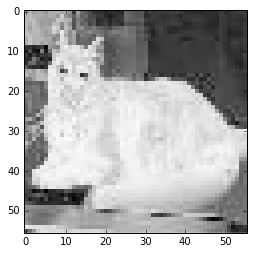

In [17]:
#Display images and check for randomization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
n=12605
image_array = (all_dataset[n])
image_array.shape

plt.imshow(image_array, cmap='Greys', interpolation='None')
print(all_labels[n])

In [18]:
## Check randomized array
print('Dataset shape:', all_dataset.shape)
print('Dataset Mean:', np.mean(all_dataset))
#print('Dataset Standard deviation:', np.std(all_dataset))
print('Dataset Max:', np.amax(all_dataset))
print('Dataset Min:', np.amin(all_dataset))
print('Target shape:', all_labels.shape)
print('Target Mean:', np.mean(all_labels))
print('Target Standard deviation:', np.std(all_labels))
print('Target Max:', np.amax(all_labels))
print('Target Min:', np.amin(all_labels))

('Dataset shape:', (25000, 56, 56))
('Dataset Mean:', -0.039582387)
('Dataset Max:', 0.50196081)
('Dataset Min:', -0.49803922)
('Target shape:', (25000,))
('Target Mean:', 0.5)
('Target Standard deviation:', 0.5)
('Target Max:', 1)
('Target Min:', 0)


In [4]:
# Save the data for future use

#pickle file with 128 pixel images
#pickle_file = 'catdog.pickle'

pickle_file = 'catdog56.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'all_dataset': all_dataset,
    'all_labels': all_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

('Unable to save data to', 'catdog56.pickle', ':', NameError("name 'all_dataset' is not defined",))


NameError: name 'all_dataset' is not defined

In [3]:
# For future runs load from pickled dataset
os.chdir(r"/Users/priyankadwivedi/Desktop/tensor")
pickle_file = 'catdog56.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    all_dataset = save['all_dataset']
    all_labels = save['all_labels']
    del save  # hint to help gc free up memory
    print('Training set', all_dataset.shape, all_labels.shape)

('Training set', (25000, 56, 56), (25000,))


In [4]:
# split the full dataset of 25k images into train - 20k images and test - 5k images 
from sklearn import cross_validation 
X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(
all_dataset, all_labels, test_size=0.2, random_state=20)

In [5]:
print("train dataset", X_train.shape, y_train.shape)
print("Validation dataset", X_valid.shape, y_valid.shape)

('train dataset', (20000, 56, 56), (20000,))
('Validation dataset', (5000, 56, 56), (5000,))


0


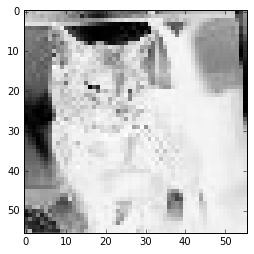

In [6]:
#Check if split has happened properly
n=2900
image_array = (X_train[n])
image_array.shape

plt.imshow(image_array, cmap='Greys', interpolation='None')
print(y_train[n])

In [7]:
# Resize training and test dataset
image_size = 56
num_labels = 2
num_channels = 1 # grayscale
def reshape(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset_full, train_labels_full = reshape(X_train, y_train)
valid_dataset_full, valid_labels_full = reshape(X_valid, y_valid)
print('Training set', train_dataset_full.shape, train_labels_full.shape)
print('Validation set', valid_dataset_full.shape, valid_labels_full.shape)

('Training set', (20000, 56, 56, 1), (20000, 2))
('Validation set', (5000, 56, 56, 1), (5000, 2))


In [8]:
#Check how labels look
n= 3105
print(train_labels_full[n])
print(np.argmax(train_labels_full[n]))
#First column - Cat
#Second column - Dog 

[ 0.  1.]
1


In [9]:
# Pickle again
os.chdir(r"/Users/priyankadwivedi/Desktop/tensor")
pickle_file = 'catdog57.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset_full': train_dataset_full,
    'train_labels_full': train_labels_full,
    'valid_dataset_full': valid_dataset_full,
    'valid_labels_full': valid_labels_full,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [15]:
#Define accuracy. Find closest integer and compare across predictions and labels
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [16]:
# create a small train dataset for testing algorithm
train_dataset= train_dataset_full[:500,:,:]
train_labels= train_labels_full[:500]
print(train_dataset.shape, train_labels.shape)
train_labels[0]

((500, 56, 56, 1), (500, 2))


array([ 0.,  1.], dtype=float32)

In [17]:
#Simple convolution neural network - 2 layers with maxpool and 1 fully connected layer at the end

batch_size = 16
num_channels = 1
num_labels = 2
image_size = 56
#keep_prob = 1.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  
  # Variables.
  def weight_variable(shape):
      initial = tf.truncated_normal(shape, stddev=0.1)
      return tf.Variable(initial)

  def bias_variable(shape):
      initial = tf.constant(0.1, shape=shape)
      return tf.Variable(initial)
    
  #Define convolution network
  def conv2d(x, W):
      return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
      return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
  
# First Convolution Layer weights and biases
  patch_size1 = 5
  depth1 = 32
  #depth1 = 16
  W_conv1 = weight_variable([patch_size1, patch_size1, num_channels, depth1])
  b_conv1 = bias_variable([depth1])
    
# Second Convolution Layer weights and biases
  patch_size2 = 5
  depth2 = 64
  #depth2 = 32
  W_conv2 = weight_variable([patch_size1, patch_size1, depth1, depth2])
  b_conv2 = bias_variable([depth2])

# Fully connected Layer
#Image size is now image_size/4
  num_neurons = 500
  #num_neurons = 64
  W_fc1 = weight_variable([(image_size/4) * (image_size/4) * depth2, num_neurons])
  b_fc1 = bias_variable([num_neurons])

#Output Layer
  W_fc2 = weight_variable([num_neurons, num_labels])
  b_fc2 = bias_variable([num_labels])
                         
                         
  def model(data):  
    # First convolution Layer
      h_conv1 = tf.nn.relu(conv2d(data, W_conv1) + b_conv1)
      h_pool1 = max_pool_2x2(h_conv1)
    # Second convolution Layer
      h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
      h_pool2 = max_pool_2x2(h_conv2)
    #Fully connected Layer
      shape = h_pool2.get_shape().as_list()
      h_pool2_flat = tf.reshape(h_pool2, [shape[0], shape[1] * shape[2] * shape[3]])
      h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    #Droput to fully connected layer
      #keep_prob = tf.placeholder(tf.float32)
      #h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    #Output Layer
      return tf.matmul(h_fc1, W_fc2) + b_fc2                   
  
  # Training computation.
  # droput = 0.75
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  # No dropout for test model 
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))

In [ ]:
num_steps = 300
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    train_acc = accuracy(predictions, batch_labels)
    valid_acc = accuracy( valid_prediction.eval(), valid_labels)
    #plt.plot(step, train_acc)
    #plt.plot(step, valid_acc)
    #plt.legend(['Train Acc', 'Validation Acc'], loc='upper left')
    #plt.show()
    if (step % 100 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))

Initialized


In [ ]:
#Steps to take on EC2
#1. Run on training set of 5000 with chosen parameters
#2. Run on training set of 5000 with updated paramters and no of steps 
#3. Run on full training set of 20k 
#4. Introduce dropout on fully connected (See code below)
#5. Introduce regularization on fully connected and learning rate decay


In [14]:
#Simple convolution neural network - 2 layers with maxpool and 1 fully connected layer at the end
# Add regularization
# Add learning rate decay
#Add droput

batch_size = 16
num_channels = 1
num_labels = 2
image_size = 56
SEED = 66227  # Set to None for random seed.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  
  # Variables.
  def weight_variable(shape):
      initial = tf.truncated_normal(shape, stddev=0.1)
      return tf.Variable(initial)

  def bias_variable(shape):
      initial = tf.constant(0.1, shape=shape)
      return tf.Variable(initial)
    
  #Define convolution network
  def conv2d(x, W):
      return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
      return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
  
# First Convolution Layer weights and biases
  patch_size1 = 5
  #depth1 = 32
  depth1 = 16
  W_conv1 = weight_variable([patch_size1, patch_size1, num_channels, depth1])
  b_conv1 = bias_variable([depth1])
    
# Second Convolution Layer weights and biases
  patch_size2 = 5
  #depth2 = 64
  depth2 = 32
  W_conv2 = weight_variable([patch_size1, patch_size1, depth1, depth2])
  b_conv2 = bias_variable([depth2])

# Fully connected Layer
#Image size is now image_size/4
  #num_neurons = 500
  num_neurons = 64
  W_fc1 = weight_variable([(image_size/4) * (image_size/4) * depth2, num_neurons])
  b_fc1 = bias_variable([num_neurons])

#Output Layer
  W_fc2 = weight_variable([num_neurons, num_labels])
  b_fc2 = bias_variable([num_labels])
                         
                         
  def model(data, train=False):  
    # First convolution Layer
      h_conv1 = tf.nn.relu(conv2d(data, W_conv1) + b_conv1)
      h_pool1 = max_pool_2x2(h_conv1)
    # Second convolution Layer
      h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
      h_pool2 = max_pool_2x2(h_conv2)
    #Fully connected Layer
      shape = h_pool2.get_shape().as_list()
      h_pool2_flat = tf.reshape(h_pool2, [shape[0], shape[1] * shape[2] * shape[3]])
      h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    #Droput to fully connecte layer at 50% probability 
      if train:
          h_fc1 = tf.nn.dropout(h_fc1, 0.5, seed=SEED)
    #Output Layer
      return tf.matmul(h_fc1, W_fc2) + b_fc2                   
  
  # Training computation.
  logits = model(tf_train_dataset,True)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # L2 regularization for the fully connected parameters.
  regularizers = (tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(b_fc1) +
                  tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(b_fc2))
                  
  # Add the regularization term to the loss.
  factor = 5e-4
  loss += factor * regularizers
  
  # Define learning rate 
  global_step = tf.Variable(0, trainable=False)
  starter_learning_rate = 0.05
  learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1000, 0.90, staircase=True)
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  # No dropout for test model 
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Initialized


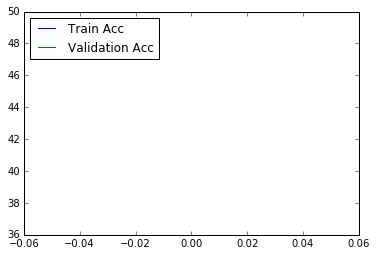

Minibatch loss at step 0: 0.844166
Minibatch accuracy: 37.5%
Validation accuracy: 49.7%


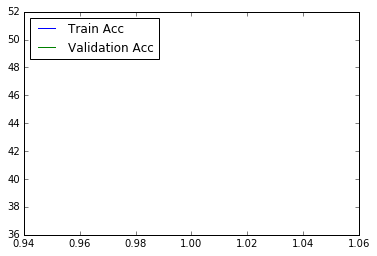

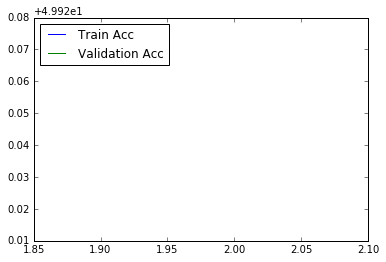

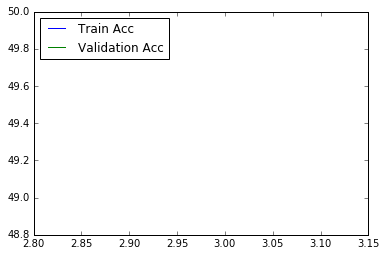

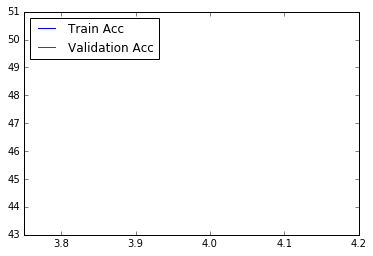

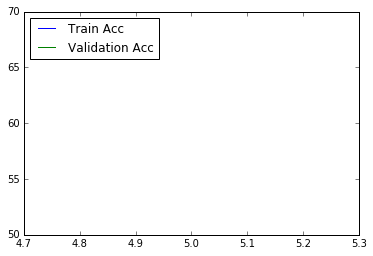

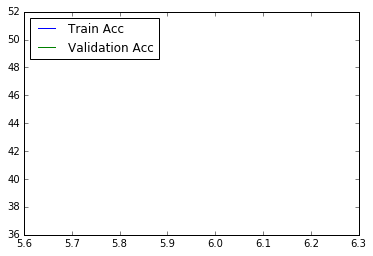

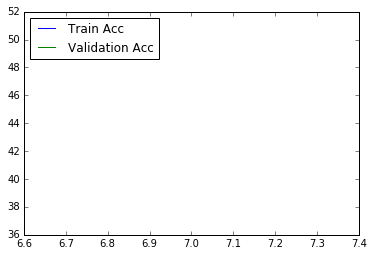

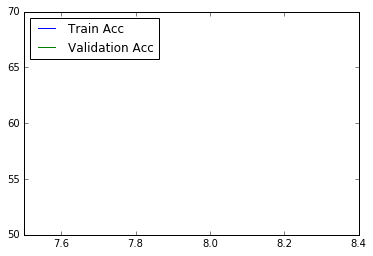

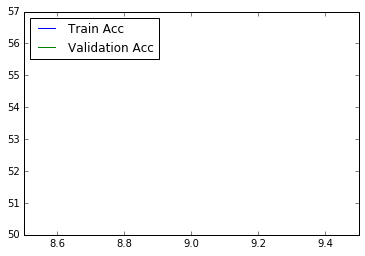

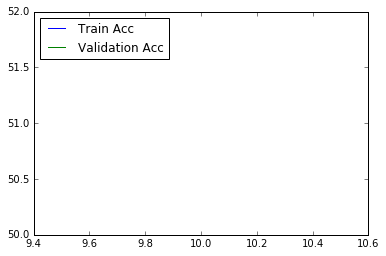

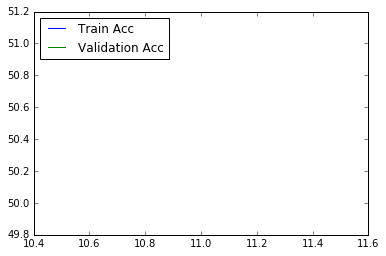

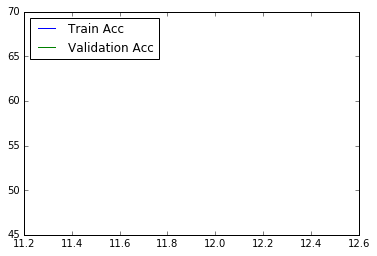

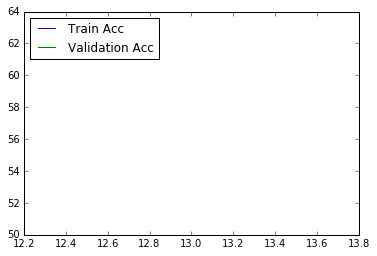

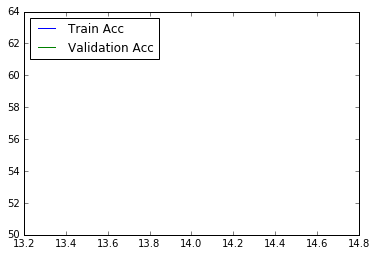

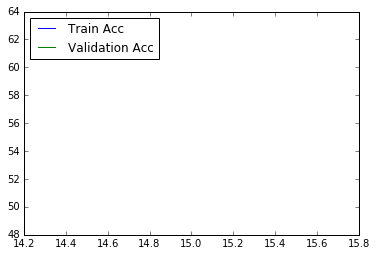

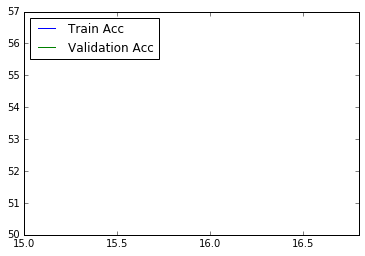

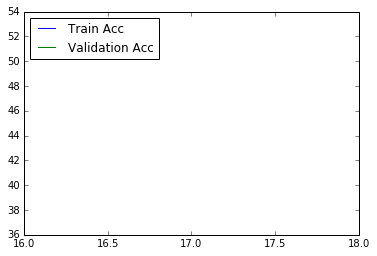

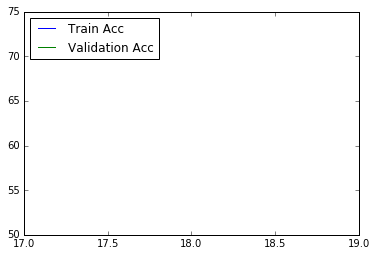

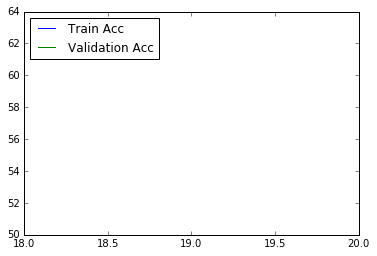

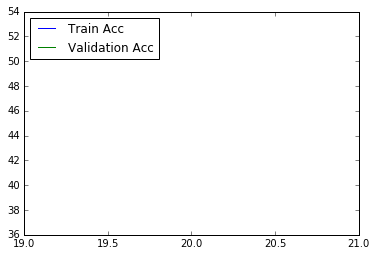

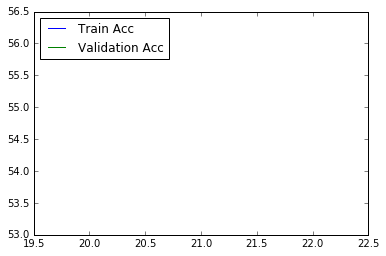

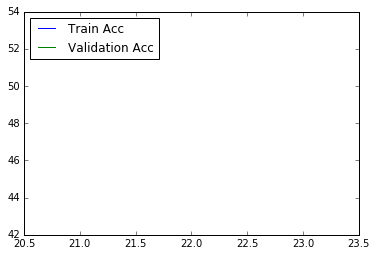

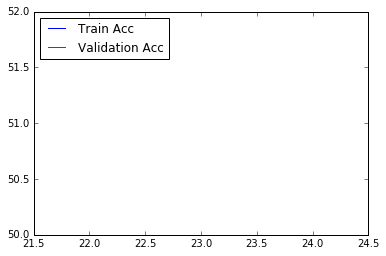

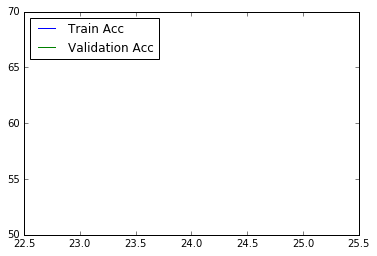

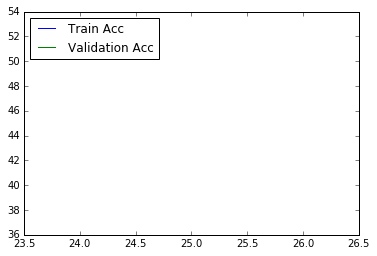

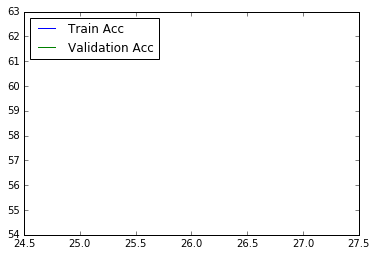

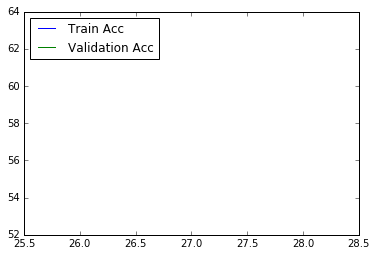

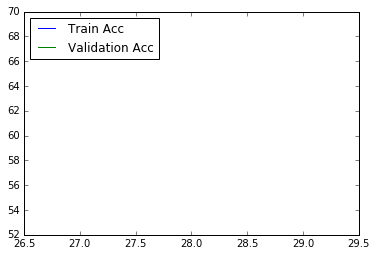

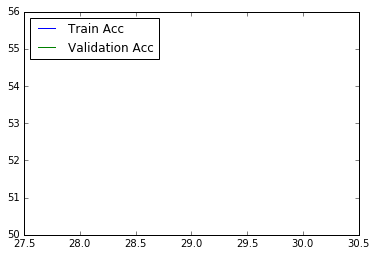

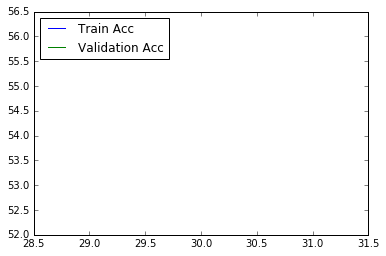

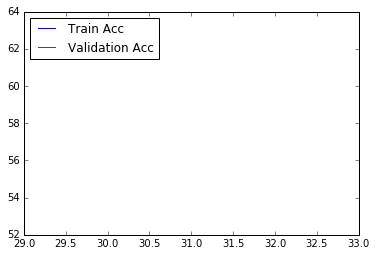

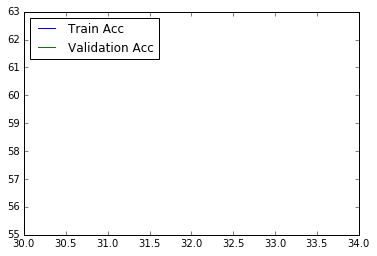

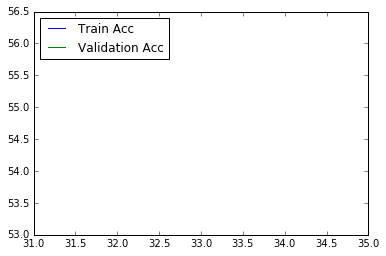

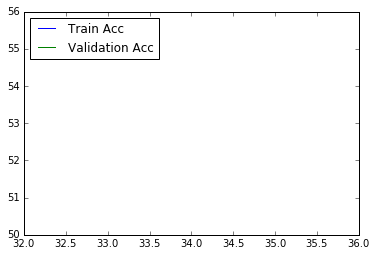

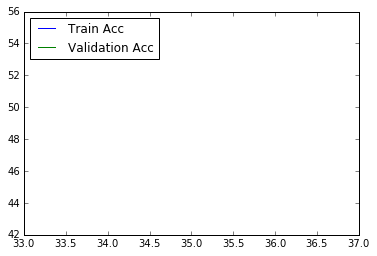

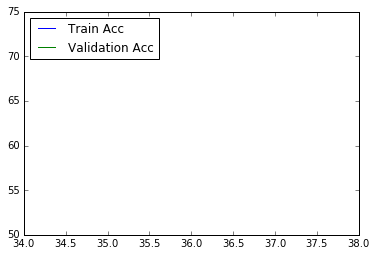

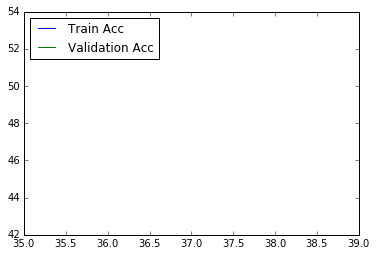

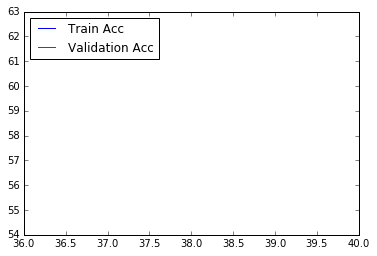

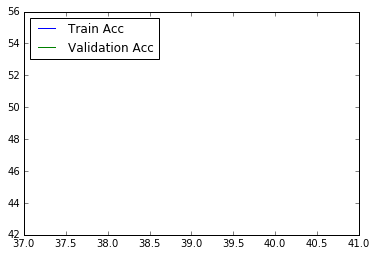

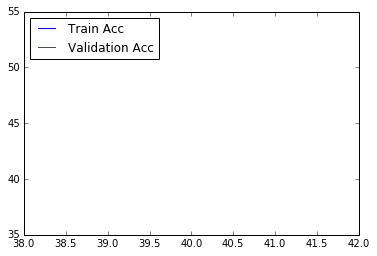

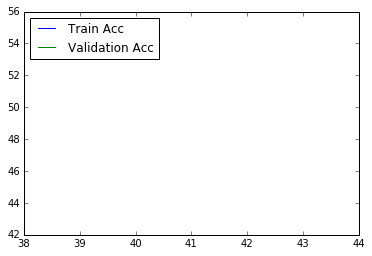

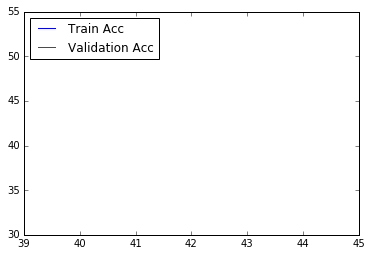

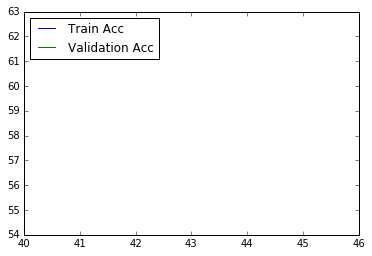

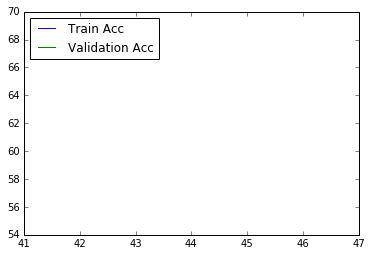

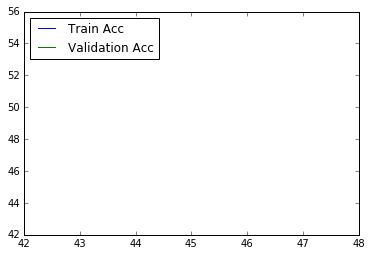

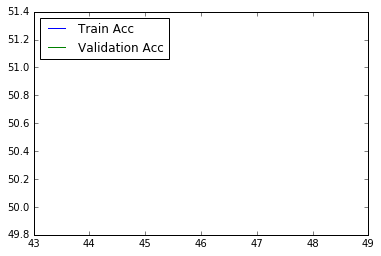

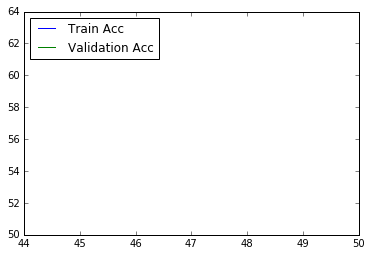

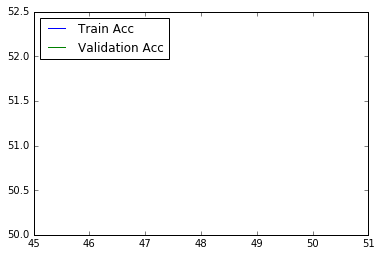

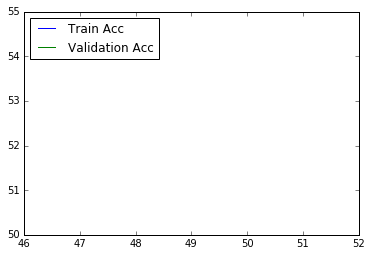

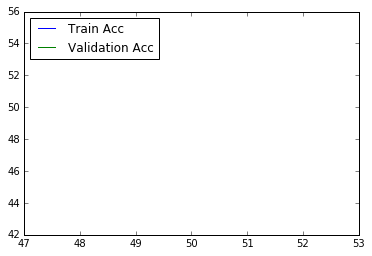

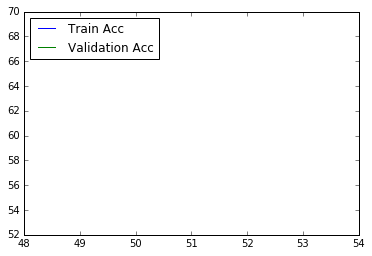

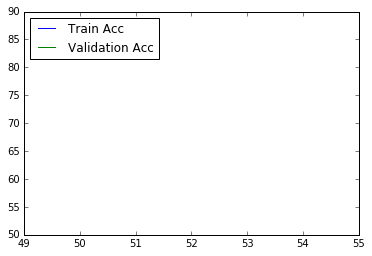

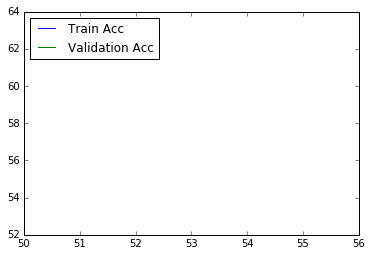

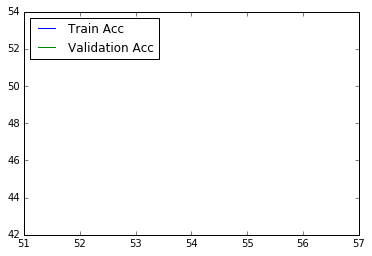

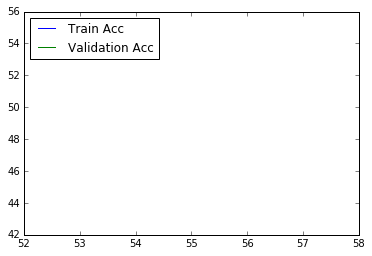

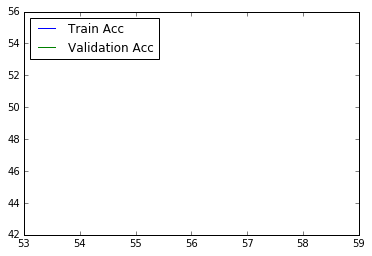

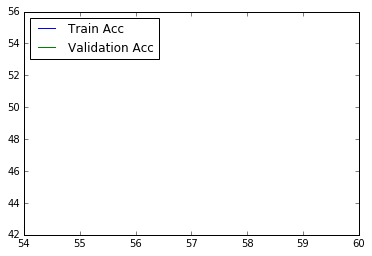

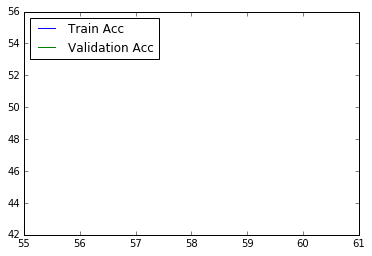

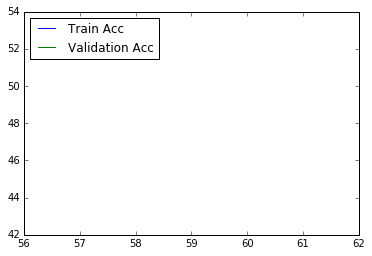

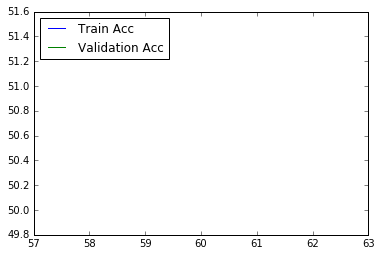

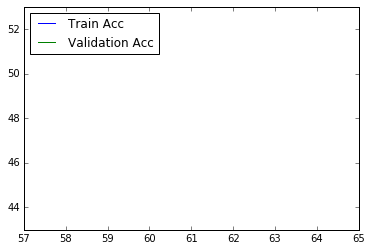

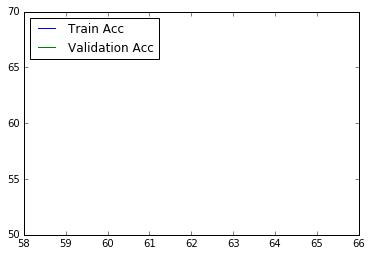

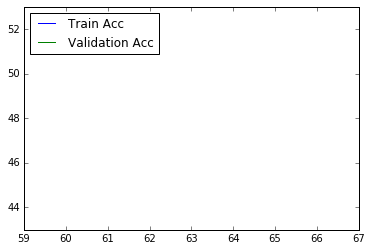

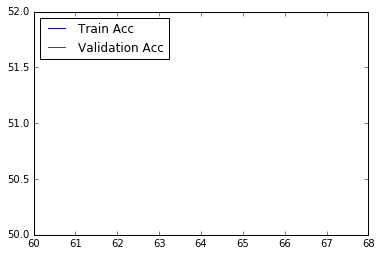

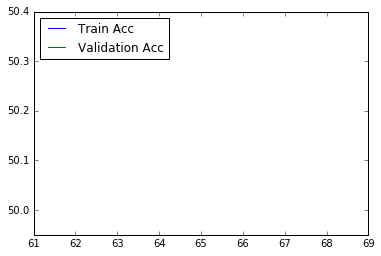

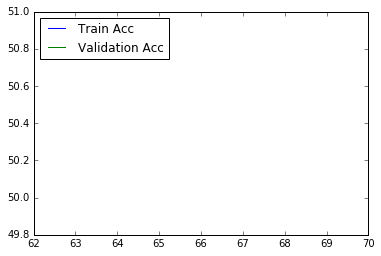

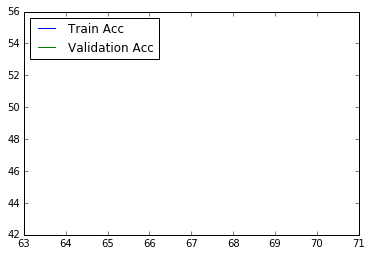

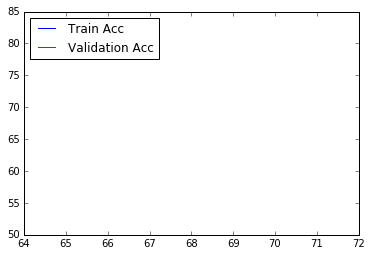

In [ ]:
num_steps = 300
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    train_acc = accuracy(predictions, batch_labels)
    valid_acc = accuracy( valid_prediction.eval(), valid_labels)
    #plt.plot(step, train_acc)
    #plt.plot(step, valid_acc)
    #plt.legend(['Train Acc', 'Validation Acc'], loc='upper left')
    #plt.show()
    if (step % 100 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))